In [336]:
import pandas as pd
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Cleaning

In [337]:
# first row appears as column names (headers)
# column names
""" 
order_id  
activation_time_local: local time when the order was activated  
country_code  
store_address  
final_status  
payment_status  
products: number of products in the order  
products_total: total amount at checkout (€)  
purchase_total_price: amount the courier paid at the store (€)   
"""

' \norder_id  \nactivation_time_local: local time when the order was activated  \ncountry_code  \nstore_address  \nfinal_status  \npayment_status  \nproducts: number of products in the order  \nproducts_total: total amount at checkout (€)  \npurchase_total_price: amount the courier paid at the store (€)   \n'

In [338]:
orders = pd.read_csv("../data/orders.csv", header=None)
orders.shape


(60400, 9)

In [339]:
orders.columns =['order_id', 'activation_time_local', 'country_code', 'store_address','final_status', 'payment_status', 'products', 'products_total','purchase_total_price']

In [340]:
orders.isna().sum()

order_id                 0
activation_time_local    0
country_code             0
store_address            0
final_status             0
payment_status           0
products                 0
products_total           0
purchase_total_price     0
dtype: int64

In [341]:
orders["payment_status"].value_counts()
#won't get rid of the not paid ones because they're not very significant and wont afect much the results

payment_status
PAID        59856
NOT_PAID      537
DELAYED         7
Name: count, dtype: int64

In [342]:
#orders["money_diference"].apply(lambda x: x = orders["products_total"] - orders["purchase_total_price"])
orders["money_diference_percentage"] = (orders["purchase_total_price"] - orders["products_total"]) / orders["products_total"] * 100

In [343]:
orders

,order_id,activation_time_local,country_code,store_address,final_status,payment_status,products,products_total,purchase_total_price,money_diference_percentage
0,33557880,2019-03-10 23:59:59.000000,AR,14200,DeliveredStatus,PAID,1,4.54,8.64,90.308370
1,33512615,2019-03-10 23:58:32.000000,TR,28725,DeliveredStatus,PAID,1,3.76,3.76,0.000000
2,33512451,2019-03-10 23:57:56.000000,TR,28725,DeliveredStatus,PAID,1,2.86,2.86,0.000000
3,33530892,2019-03-10 23:57:33.000000,ES,19777,CanceledStatus,PAID,1,12.95,0.00,-100.000000
4,33557765,2019-03-10 23:57:21.000000,AR,34565,DeliveredStatus,PAID,2,2.86,6.48,126.573427
...,...,...,...,...,...,...,...,...,...,...
60395,31960607,2019-03-01 00:04:31.000000,TR,68820,DeliveredStatus,PAID,2,10.17,10.33,1.573255
60396,32002079,2019-03-01 00:03:53.000000,AR,50175,CanceledStatus,PAID,1,3.80,0.00,-100.000000
60397,32002046,2019-03-01 00:03:06.000000,AR,55159,DeliveredStatus,PAID,1,4.24,4.91,15.801887
60398,32001950,2019-03-01 00:01:01.000000,AR,62504,CanceledStatus,PAID,1,4.91,0.00,-100.000000


### Question 1

In [344]:
all = len(orders["money_diference_percentage"])
under_authorized = len(orders[orders["money_diference_percentage"]< 0])

under_authorized_percentage = (under_authorized / all) * 100

In [345]:
under_authorized_percentage
# percentage of under authoridzed orders

21.961920529801322

### Question 2

In [346]:
# What percent of orders would be correctly authorized w/ incremental authorisation  
# (+20%) on the amount at checkout? 

In [347]:
def check_orders(df, threshold, operator):
  all_orders = len(df["money_diference_percentage"])
  under_authorized = len(df[operator(df["money_diference_percentage"], threshold)])

  order_type_percentage = (under_authorized / all_orders) * 100

  if threshold ==0:
    return f"{order_type_percentage}% of the orders are under authoridzed orders"
  else:
    return f"{order_type_percentage}% of the orders are correctly authorized w/ incremental authorization"

In [348]:
check_orders(orders, 0, operator.lt)

'21.961920529801322% of the orders are under authoridzed orders'

In [349]:
check_orders(orders, 20, operator.gt)

'30.96688741721854% of the orders are correctly authorized w/ incremental authorization'

### Question 3

In [350]:
orders["country_code"].value_counts()

country_code
AR    13192
ES    12806
TR     6348
PE     4785
UA     4119
IT     2808
EC     2508
RO     2167
FR     2136
EG     1828
MA     1632
CR     1107
CL     1104
PA     1013
PT      909
GT      567
GE      546
DO      500
UY      190
KE       94
PR       33
CI        6
BR        2
Name: count, dtype: int64

In [351]:
grouped = orders.query("money_diference_percentage < 0").groupby("country_code")
grouped_df = pd.DataFrame(grouped["money_diference_percentage"].count())
grouped_df.sort_values("money_diference_percentage", ascending=False)

,money_diference_percentage
country_code,
ES,3195
AR,2842
TR,1130
PE,866
IT,852
UA,793
FR,607
RO,474
EC,431


In [352]:
def check_by_group(df, p_type, percentage, operator):
  if p_type == "country":
    grouped = df[operator(df["money_diference_percentage"], percentage)].groupby("country_code")

  elif p_type == "store":
    grouped = df[operator(df["money_diference_percentage"], percentage)].groupby("store_address")
    
  else:
    return "invalid parameter, should be 'country' or 'store'"

  df = pd.DataFrame(grouped["money_diference_percentage"].count())
  top_10 = df.sort_values("money_diference_percentage", ascending=False).head(10)
  top_10 = top_10.reset_index()
  return top_10
  

In [353]:
under_authorized_by_country = check_by_group(orders, "country", 0, operator.lt)

In [354]:
over_authorized_by_country= check_by_group(orders, "country", 0, operator.gt)

In [355]:
under_authorized_by_store = check_by_group(orders, "store", 0, operator.lt)

In [356]:
over_authorized_by_store = check_by_group(orders, "store", 0, operator.gt)

In [372]:
def count_plot(df, title=None, xlabel=None, ylabel=None):
  column1 = df.iloc[:, 0]
  column2 = df.iloc[:, 1]
  sns.barplot(data=df, x=column1, y=column2, palette="Blues")
  plt.xticks(rotation=45)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

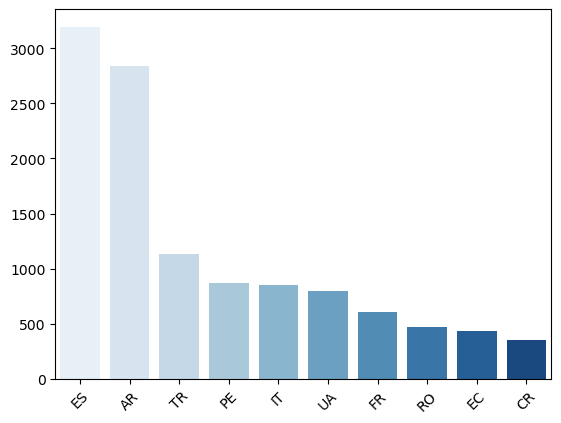

In [373]:
count_plot(under_authorized_by_country)

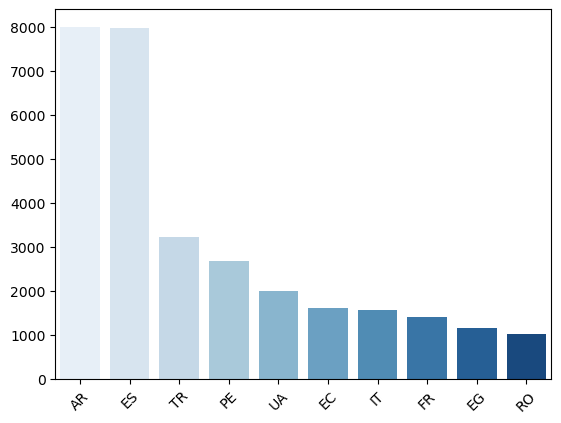

In [374]:
count_plot(over_authorized_by_country)

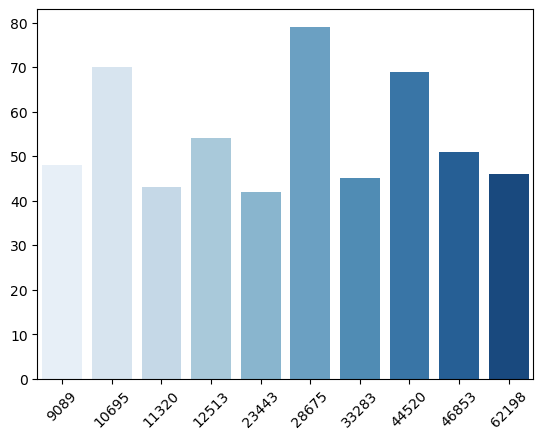

In [375]:
count_plot(under_authorized_by_store)

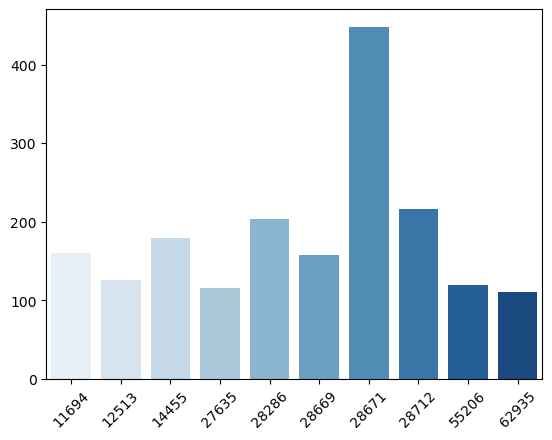

In [376]:
count_plot(over_authorized_by_store)

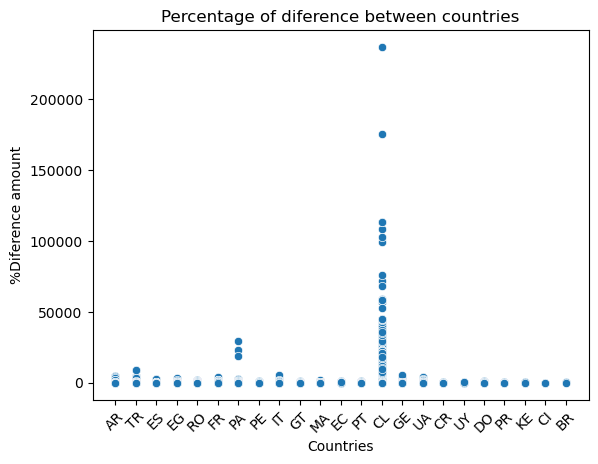

In [362]:
sns.scatterplot(data=orders, x='country_code', y='money_diference_percentage')
plt.xticks(rotation=45)
plt.xlabel("Countries")
plt.ylabel("%Diference amount")
plt.title("Percentage of diference between countries")
plt.show();

In [363]:
merged_by_country = pd.merge(under_authorized_by_country, over_authorized_by_country, on="country_code", how="inner")
merged_by_country

,country_code,money_diference_percentage_x,money_diference_percentage_y
0,ES,3195,7965
1,AR,2842,7994
2,TR,1130,3216
3,PE,866,2675
4,IT,852,1553
5,UA,793,2003
6,FR,607,1402
7,RO,474,1006
8,EC,431,1611


In [364]:
merged_by_store = pd.merge(under_authorized_by_store, over_authorized_by_store, on="store_address", how="inner")
merged_by_store

,store_address,money_diference_percentage_x,money_diference_percentage_y
0,12513,54,126


In [365]:
cleaned_orders = orders.query("final_status != 'CanceledStatus'")
cleaned_orders

,order_id,activation_time_local,country_code,store_address,final_status,payment_status,products,products_total,purchase_total_price,money_diference_percentage
0,33557880,2019-03-10 23:59:59.000000,AR,14200,DeliveredStatus,PAID,1,4.54,8.64,90.308370
1,33512615,2019-03-10 23:58:32.000000,TR,28725,DeliveredStatus,PAID,1,3.76,3.76,0.000000
2,33512451,2019-03-10 23:57:56.000000,TR,28725,DeliveredStatus,PAID,1,2.86,2.86,0.000000
4,33557765,2019-03-10 23:57:21.000000,AR,34565,DeliveredStatus,PAID,2,2.86,6.48,126.573427
5,33512273,2019-03-10 23:57:13.000000,TR,63536,DeliveredStatus,PAID,4,1.88,1.96,4.255319
...,...,...,...,...,...,...,...,...,...,...
60393,31961779,2019-03-01 00:09:57.000000,TR,34953,DeliveredStatus,PAID,1,1.80,1.80,0.000000
60394,32002340,2019-03-01 00:09:21.000000,AR,14455,DeliveredStatus,NOT_PAID,2,5.14,5.14,0.000000
60395,31960607,2019-03-01 00:04:31.000000,TR,68820,DeliveredStatus,PAID,2,10.17,10.33,1.573255
60397,32002046,2019-03-01 00:03:06.000000,AR,55159,DeliveredStatus,PAID,1,4.24,4.91,15.801887


In [366]:
check_orders(cleaned_orders, 0, operator.lt)

'13.379589262193198% of the orders are under authoridzed orders'

In [367]:
check_orders(cleaned_orders, 20, operator.gt)

'34.322764966699445% of the orders are correctly authorized w/ incremental authorization'

In [368]:
under_authorized_by_country_no_cancel = check_by_group(cleaned_orders, "country", 0, operator.lt)
over_authorized_by_country_no_cancel = check_by_group(cleaned_orders, "country", 20, operator.gt)
under_authorized_by_store_no_cancel = check_by_group(cleaned_orders, "store", 0, operator.lt)
over_authorized_by_store_no_cancel = check_by_group(cleaned_orders, "store", 20, operator.gt)

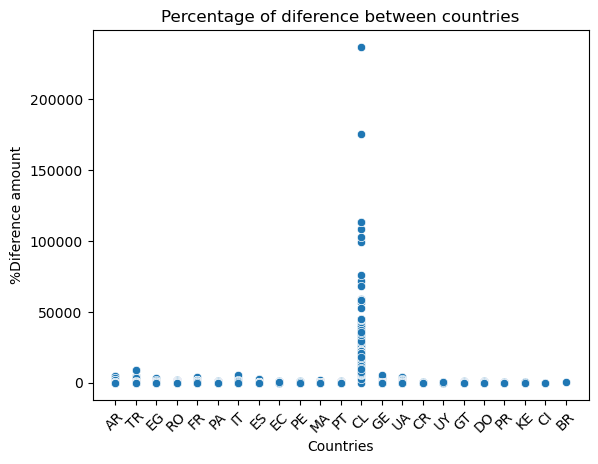

In [369]:
sns.scatterplot(data=cleaned_orders, x='country_code', y='money_diference_percentage')
plt.xticks(rotation=45)
plt.xlabel("Countries")
plt.ylabel("%Diference amount")
plt.title("Percentage of diference between countries")
plt.show();

In [370]:
def average_of_df(df):
  df.groupby("final_status")["purchase_total_price"].mean().reset_index()

In [371]:
orders.groupby("final_status")["purchase_total_price"].mean().reset_index()

,final_status,purchase_total_price
0,CanceledStatus,1.481679
1,DeliveredStatus,11.814959
